# One Shot Learning with Siamese Networks

This is the jupyter notebook that accompanies

## Imports
All the imports are defined here

In [107]:
%matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import pandas as pd

## Helper functions
Set of helper functions

In [87]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

## Configuration Class
A simple class to manage configuration

In [88]:
class Config():
    training_dir = "./data/pills/training/"
    testing_dir = "./data/pills/testing/"
    train_batch_size = 8
    train_number_epochs = 100

## Custom Dataset Class
This dataset generates a pair of images. 0 for geniune pair and 1 for imposter pair

In [89]:
class SiameseNetworkDataset(Dataset):
    
    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)
        #we need to make sure approx 50% of images are in the same class
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
                #keep looping till the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1]==img1_tuple[1]:
                    break
        else:
            while True:
                #keep looping till a different class image is found
                
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] !=img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        #img0 = img0.convert("L")
        #img1 = img1.convert("L")
        
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1 , torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32)), torch.from_numpy(np.array([int(img0_tuple[1])],dtype=np.float32)),torch.from_numpy(np.array([int(img1_tuple[1])],dtype=np.float32))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

## Using Image Folder Dataset

In [90]:
folder_dataset = dset.ImageFolder(root=Config.training_dir)

In [91]:
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

In [92]:
img0_tuple = random.choice(folder_dataset.imgs)

In [93]:
img0_tuple

('./data/pills/training/p508/359.jpeg', 17)

## Visualising some of the data
The top row and the bottom row of any column is one pair. The 0s and 1s correspond to the column of the image.
1 indiciates dissimilar, and 0 indicates similar.

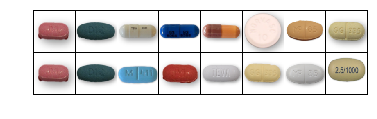

[[0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]]


In [94]:
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=8)
dataiter = iter(vis_dataloader)


example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

## Neural Net Definition
We will use a standard convolutional neural network

In [95]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(3, 12, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(12),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(12, 12, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(12),


            nn.ReflectionPad2d(1),
            nn.Conv2d(12, 24, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(24),


        )

        self.fc1 = nn.Sequential(
            nn.Linear(24*100*100, 20),
            nn.ReLU(inplace=True),

            nn.Linear(20, 20),
            nn.ReLU(inplace=True),

            nn.Linear(20, 5))

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

## Contrastive Loss

In [96]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=0.5):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

## Training Time!

In [97]:
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=Config.train_batch_size)

In [98]:
net = SiameseNetwork()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(),lr = 0.0005 )

In [99]:
counter = []
loss_history = [] 
iteration_number= 0

Epoch number 0
 Current loss 0.05317341536283493

Epoch number 0
 Current loss 4.013765335083008

Epoch number 1
 Current loss 1.7938743829727173

Epoch number 1
 Current loss 4.317684173583984

Epoch number 2
 Current loss 2.324709892272949

Epoch number 2
 Current loss 0.288144052028656

Epoch number 3
 Current loss 0.4410654902458191

Epoch number 3
 Current loss 0.7140541672706604

Epoch number 4
 Current loss 0.8464481830596924

Epoch number 4
 Current loss 0.450569748878479

Epoch number 5
 Current loss 0.22969312965869904

Epoch number 5
 Current loss 4.908888339996338

Epoch number 6
 Current loss 0.2999287545681

Epoch number 6
 Current loss 0.19303512573242188

Epoch number 7
 Current loss 0.29665660858154297

Epoch number 7
 Current loss 0.31559330224990845

Epoch number 8
 Current loss 0.3066401481628418

Epoch number 8
 Current loss 0.151908740401268

Epoch number 9
 Current loss 0.18301406502723694

Epoch number 9
 Current loss 0.19314154982566833

Epoch number 10
 Curren

Epoch number 81
 Current loss 0.07343370467424393

Epoch number 81
 Current loss 0.07091229408979416

Epoch number 82
 Current loss 0.07362597435712814

Epoch number 82
 Current loss 0.0802830308675766

Epoch number 83
 Current loss 0.07411474734544754

Epoch number 83
 Current loss 0.07097378373146057

Epoch number 84
 Current loss 0.06668678671121597

Epoch number 84
 Current loss 0.07329712808132172

Epoch number 85
 Current loss 0.07481148093938828

Epoch number 85
 Current loss 0.08481249958276749

Epoch number 86
 Current loss 0.061897046864032745

Epoch number 86
 Current loss 0.07322852313518524

Epoch number 87
 Current loss 0.06151384487748146

Epoch number 87
 Current loss 0.07738909125328064

Epoch number 88
 Current loss 0.08125413954257965

Epoch number 88
 Current loss 0.08721181750297546

Epoch number 89
 Current loss 0.09149127453565598

Epoch number 89
 Current loss 0.07503771036863327

Epoch number 90
 Current loss 0.07748940587043762

Epoch number 90
 Current loss 0

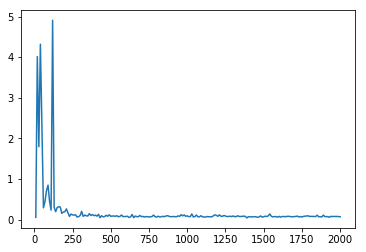

In [83]:
for epoch in range(0,Config.train_number_epochs):
    for i, data in enumerate(train_dataloader,0):
        img0, img1 , label, _, _ = data
        img0, img1 , label = img0, img1 , label
        optimizer.zero_grad()
        output1,output2 = net(img0,img1)
        loss_contrastive = criterion(output1,output2,label)
        loss_contrastive.backward()
        optimizer.step()
        if i %10 == 0 :
            print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())
show_plot(counter,loss_history)

## Some simple testing
The last 3 subjects were held out from the training, and will be used to test. The Distance between each image pair denotes the degree of similarity the model found between the two images. Less means it found more similar, while higher values indicate it found them to be dissimilar.

tensor([[4.]]) tensor([[1.]])


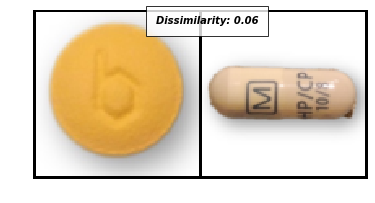

In [139]:
folder_dataset_test = dset.ImageFolder(root=Config.testing_dir)
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

test_dataloader = DataLoader(siamese_dataset,num_workers=6,batch_size=1,shuffle=False)
dataiter = iter(test_dataloader)
x0,_,_,class0, _ = next(dataiter)

for i in range(1):
    _,x1,_, _, class1 = next(dataiter)
    concatenated = torch.cat((x0,x1),0)
    print(class0, class1)
    
    output1,output2 = net(Variable(x0),Variable(x1))
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(euclidean_distance.item()))



In [176]:
folder_dataset_test = dset.ImageFolder(root=Config.testing_dir)
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

test_dataloader = DataLoader(siamese_dataset,num_workers=6,batch_size=1,shuffle=False)

cols = ['class0','class1', 'output', 'dissimilarity']
lst = []

for i_batch, sample_batched in enumerate(test_dataloader):
    x0 = sample_batched[0]
    class0 = sample_batched[3]
    for i_batch, sample_batched in enumerate(test_dataloader):
        x1 = sample_batched[1]
        class1 = sample_batched[4]
        concatenated = torch.cat((x0,x1),0)
        output1,output2 = net(Variable(x0),Variable(x1))
        euclidean_distance = F.pairwise_distance(output1, output2)
        if class0.item() == class1.item():
            image_tup = 0
        else:
            image_tup = 1
        lst.append([class0.item(), class1.item(), image_tup, euclidean_distance.item()])
        #print(class0.item(), class1.item(), image_tup, euclidean_distance.item())

        
df = pd.DataFrame(lst, columns=cols)
train_set = df

In [177]:
df.head(n=5)

,class0,class1,output,dissimilarity
0,1.0,4.0,1,0.119562
1,1.0,3.0,1,0.081319
2,1.0,4.0,1,0.081064
3,1.0,1.0,0,0.054771
4,1.0,3.0,1,0.167007


In [178]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
df['output'].value_counts()

1    488
0    137
Name: output, dtype: int64

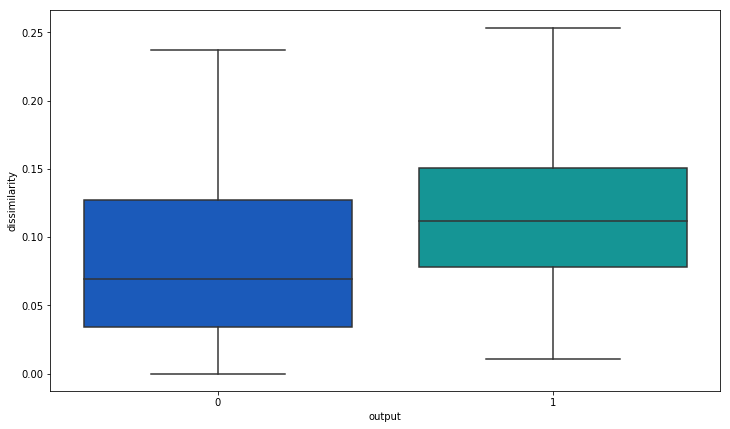

In [179]:
plt.figure(figsize=(12, 7))
sns.boxplot(x='output',y='dissimilarity',data=df,palette='winter')

In [168]:
#rand = np.random.randint(2, size=len(df))
#df['random_guess'] = rand.tolist()
#df

In [180]:
dissimilarity_score = np.arange(0.0,max(df['dissimilarity']), 0.01)
cols = ['dissimilarity_score', 'accuracy', 'accuracy_random']
lst = []

for i in dissimilarity_score:
    df['prediction'] = 0
    df['prediction'][df['dissimilarity'] >= i] = 1
   
    df['correct'] = 0
    df['correct'][df['prediction']  == df['output']] = 1
    
    rand = np.random.randint(2, size=len(df))
    df['random_guess'] = rand.tolist()
    df['correct_guess'] = 0
    df['correct_guess'][df['random_guess'] == df['output']] = 1
    
    acc = sum(df['correct']) / len(df)
    acc_guess = sum(df['correct_guess']) / len(df)
    lst.append([i, acc, acc_guess])

df = pd.DataFrame(lst, columns=cols)
df

/Users/matthewpotts/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/Users/matthewpotts/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/matthewpotts/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app

,dissimilarity_score,accuracy,accuracy_random
0,0.00,0.7808,0.4896
1,0.01,0.8256,0.5184
2,0.02,0.8192,0.5024
3,0.03,0.8272,0.5136
4,0.04,0.8032,0.5104
5,0.05,0.7904,0.5392
6,0.06,0.7584,0.5072
7,0.07,0.7376,0.4512
8,0.08,0.6976,0.5216
9,0.09,0.6416,0.5200


In [184]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 625 entries, 0 to 624
Data columns (total 8 columns):
class0           625 non-null float64
class1           625 non-null float64
output           625 non-null int64
dissimilarity    625 non-null float64
prediction       625 non-null int64
correct          625 non-null int64
random_guess     625 non-null int64
correct_guess    625 non-null int64
dtypes: float64(3), int64(5)
memory usage: 39.1 KB


In [186]:
train_set.drop(['class0','class1','prediction','correct','random_guess','correct_guess'],axis=1,inplace=True)

In [187]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_set.drop('output',axis=1), 
                                                    train_set['output'], test_size=0.30, 
                                                    random_state=101)

In [188]:
from sklearn.linear_model import LogisticRegression
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)
predictions = logmodel.predict(X_test)

/Users/matthewpotts/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [189]:
from sklearn.metrics import classification_report
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        40
           1       0.79      1.00      0.88       148

   micro avg       0.79      0.79      0.79       188
   macro avg       0.39      0.50      0.44       188
weighted avg       0.62      0.79      0.69       188



/Users/matthewpotts/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/matthewpotts/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/matthewpotts/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [16]:
folder_dataset_test = dset.ImageFolder(root=Config.testing_dir)
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)


In [20]:
test_dataloader = DataLoader(siamese_dataset,num_workers=6,batch_size=1,shuffle=True)

In [21]:
dataiter = iter(test_dataloader)

In [22]:
dataiter

In [93]:
x0,_,_ = next(dataiter)

In [94]:
_

tensor([[0.]])

In [95]:
x0

tensor([[[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],

         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],

         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]]])

In [100]:
x0.size()

torch.Size([1, 3, 100, 100])

In [104]:
x0[0][0][0][1]


tensor(1.)

In [99]:
x1.size()

torch.Size([1, 3, 100, 100])

In [105]:
x1[0][0][0][1]

tensor(1.)

In [106]:
x1

tensor([[[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 0.9961, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 0.9961, 0.9961, 1.0000],
          ...,
          [1.0000, 1.0000, 0.9961,  ..., 0.9804, 0.9843, 0.9882],
          [1.0000, 1.0000, 0.9961,  ..., 0.9843, 0.9882, 0.9922],
          [1.0000, 1.0000, 1.0000,  ..., 0.9882, 0.9882, 0.9922]],

         [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 0.9961, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 0.9961, 0.9961, 1.0000],
          ...,
          [1.0000, 1.0000, 0.9961,  ..., 0.9804, 0.9843, 0.9882],
          [1.0000, 1.0000, 0.9961,  ..., 0.9843, 0.9882, 0.9922],
          [1.0000, 1.0000, 1.0000,  ..., 0.9882, 0.9882, 0.9922]],

         [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 0.9961, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 0

In [ ]:
for i in range(100):
    _,x1,label2 = next(dataiter)
    print(label2)
    print(_)
    print(x1)
    print(i)
    concatenated = torch.cat((x0,x1),0)
    
    output1,output2 = net(Variable(x0),Variable(x1))
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(euclidean_distance.item()))
    print(euclidean_distance)
